In [38]:
import numpy as np
from collections import Counter
# from DecisionTree import DecisionTree

### Implement the Decision Tree in order to implement Random Forest on top of it

#### Create A Node Class

In [41]:
class Node:
    def __init__(self, feature = None, threshold = None, left = None, right = None, *, value = None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

#### Create Decision Tree Class

In [67]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # Check the stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # Find the best split
        best_feature, best_threshold = self._best_split(X, y, feat_idxs)

        # If no valid split is found, create a leaf node
        if best_feature is None or best_threshold is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)

        # Ensure splits are valid
        if left_idxs is None or right_idxs is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_threshold, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thresh in thresholds:
                # Calculate the information gain
                gain = self._information_gain(y, X_column, thresh)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thresh

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        # Parent entropy
        parent_entropy = self._entropy(y)

        # Create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        # Return 0 if no valid split
        if left_idxs is None or right_idxs is None:
            return 0

        # Calculate the weighted avg entropy of the children 
        n = len(y)
        n_left, n_right = len(left_idxs), len(right_idxs)
        e_left, e_right = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_left / n) * e_left + (n_right / n) * e_right

        # Calculate the Information Gain
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()

        # Avoid splitting if it results in empty sets
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return None, None

        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        if len(y) == 0:
            raise ValueError("The input array 'y' is empty. Cannot determine the most common label.")

        counter = Counter(y)
        if not counter:
            raise ValueError("Counter is empty. Cannot determine the most common label.")

        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


### Implement Random Forest

In [75]:
class RandomForest:
    def __init__(self, n_trees = 10, max_depth = 10, min_samples_split = 2, n_features = None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []
        
        
    def fit(self,X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth = self.max_depth,
                                min_samples_split = self.min_samples_split,
                               n_features = self.n_features)
            
            X_sample, y_sample = self._bootstrap_samples(X,y)
            tree.fit(X_sample,y_sample)
            self.trees.append(tree)
            
            
    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace = True)
        return X[idxs], y[idxs]
    
    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common
    
    
    def predict (self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions    

### Let's Import the Libraries

In [22]:
import numpy as np
import pandas as pd

### Import Dataset

In [14]:
dataset = pd.read_csv('Social_Network_Ads.csv')
dataset.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


#### Split into input features (X) and target value (y)

In [16]:
X = dataset.iloc[:, 0 : 2].values
y = dataset.iloc[:, -1].values
print('X shape', X.shape)
print('y shape', y.shape)

X shape (400, 2)
y shape (400,)


### Scale the feature X

In [21]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X[0:6, :]

array([[-1.78179743, -1.49004624],
       [-0.25358736, -1.46068138],
       [-1.11320552, -0.78528968],
       [-1.01769239, -0.37418169],
       [-1.78179743,  0.18375059],
       [-1.01769239, -0.34481683]])

### Split into training & test set

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1234)
print('X_train Shape :',X_train.shape)
print('y_train Shape :',y_train.shape)
print('X_test Shape :',X_test.shape)
print('y_test Shape :',y_test.shape)

X_train Shape : (320, 2)
y_train Shape : (320,)
X_test Shape : (80, 2)
y_test Shape : (80,)


### Let's Fit the model

In [84]:
classifier = RandomForest()
classifier.fit(X_train, y_train)

### Let's do prediction with the random forest classifier

In [85]:
predictions = classifier.predict(X_test)

### Accuracy

In [87]:
accuracy = np.mean(predictions == y_test)
print('Accuracy :',accuracy)

Accuracy : 0.9


### Let's set n_trees = 20

In [134]:
classifier = RandomForest(n_trees = 20, max_depth = 5)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
accuracy = np.mean(predictions == y_test)
print('Accuracy :',accuracy)

Accuracy : 0.9


### Let's Use the Scikit Learn Library to implement the Random Forest

We will compare the results as accuracy and visual of our custom implemented Random Forest and Scikit Learn Random Forest Model for the same Social Network Ads dataset

In [148]:
from sklearn.ensemble import RandomForestClassifier

clr = RandomForestClassifier(n_estimators=20, max_depth=5, min_samples_split=2) # Hyperperamter is just like ours
clr.fit(X_train, y_train)
preds = clr.predict(X_test)
acc = np.mean(preds == y_test)
print('Acc :',acc)

Acc : 0.8875


The accuracy of our custom model is 90% and sklearn is 88.75% which is quite well

Now let's Compare through visualization

### Results from using our Model

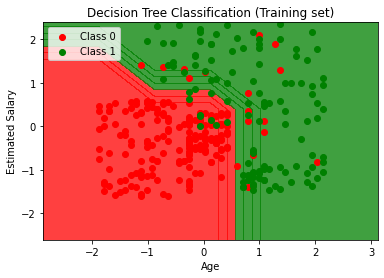

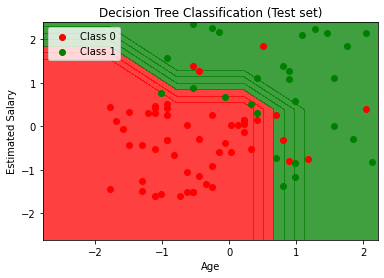

In [150]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define a reasonable step size
step_size = 1  # Increase this value to reduce memory usage

# Visualising the Training set results
X_set, y_set = sc.inverse_transform(X_train), y_train
X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=step_size),
                     np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=step_size))

# Predicting on mesh grid with subsampling
Z = classifier.predict(sc.transform(np.c_[X1.ravel(), X2.ravel()]))
Z = Z.reshape(X1.shape)

# Plotting decision boundary
plt.contourf(X1, X2, Z, alpha=0.75, cmap=ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

# Plotting training points with subsampling
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], 
                color=ListedColormap(('red', 'green'))(i), label=f'Class {j}')
    
plt.title('Decision Tree Classification (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

# Visualising the Test set results
X_set, y_set = sc.inverse_transform(X_test), y_test
X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=step_size),
                     np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=step_size))

# Predicting on mesh grid with subsampling
Z = classifier.predict(sc.transform(np.c_[X1.ravel(), X2.ravel()]))
Z = Z.reshape(X1.shape)

# Plotting decision boundary
plt.contourf(X1, X2, Z, alpha=0.75, cmap=ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

# Plotting test points with subsampling
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], 
                color=ListedColormap(('red', 'green'))(i), label=f'Class {j}')
    
plt.title('Decision Tree Classification (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

### Results from using scikit-learn Model

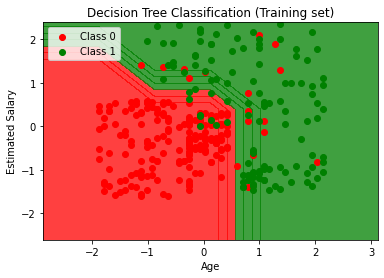

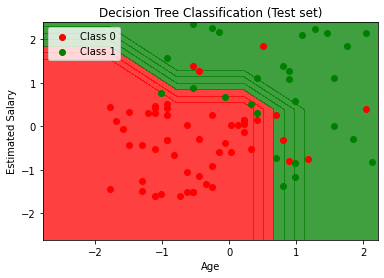

In [152]:
# Define a reasonable step size
step_size = 1  # Increase this value to reduce memory usage

# Visualising the Training set results
X_set, y_set = sc.inverse_transform(X_train), y_train
X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=step_size),
                     np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=step_size))

# Predicting on mesh grid with subsampling
Z = clr.predict(sc.transform(np.c_[X1.ravel(), X2.ravel()]))
Z = Z.reshape(X1.shape)

# Plotting decision boundary
plt.contourf(X1, X2, Z, alpha=0.75, cmap=ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

# Plotting training points with subsampling
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], 
                color=ListedColormap(('red', 'green'))(i), label=f'Class {j}')
    
plt.title('Decision Tree Classification (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

# Visualising the Test set results
X_set, y_set = sc.inverse_transform(X_test), y_test
X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=step_size),
                     np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=step_size))

# Predicting on mesh grid with subsampling
Z = clr.predict(sc.transform(np.c_[X1.ravel(), X2.ravel()]))
Z = Z.reshape(X1.shape)

# Plotting decision boundary
plt.contourf(X1, X2, Z, alpha=0.75, cmap=ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

# Plotting test points with subsampling
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], 
                color=ListedColormap(('red', 'green'))(i), label=f'Class {j}')
    
plt.title('Decision Tree Classification (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()